# Naive Bayes

Naive Bayes (Bayes Ingenuo) se refiere al uso del teorema de Bayes suponiendo (ingenuamente) que nuestros "features" son independientes.

Los clasificadores Naive Bayes son populares para categorizar texto. El objetivo de este módulo es aprender los conceptos básicos de Naive Bayes y las maneras en que Naive Bayes puede ser mejorado para realizar analisis de sentimiento. El modulo está dividido en las siguientes secciones:

+ Preparar la data para analisis
+ Introducción a Naive Bayes
+ Mejora 1: Manejo de la negación
+ Mejora 2: Bigramas
+ Mejora 3: Binary count Naive Bayes
+ Mejora 4: Manejo de texto informal

Este módulo coincide con la lecture sobre mejorar Naive Bayes para análisis de sentimiento.

Antes de profundizar en la sección 1 acerca de la preparación de datos, comenzaremos haciendo una descripción general de los datos que estamos utilizando. Vamos a usar la siguiente metodología:

1. Primero, extrajimos los datos de Twitter relacionados a microfinanzas (microfinance) usando tweepy, que es una librería API de Twitter.
2. Después, clasificamos los comentarios en polaridades de sentimiento para obtener los datos de entrenamiento para nuestro modelo.
    + Normalmente, este proceso requeriría clasificar manualmente el 20% de los datos (aprox.).
    + En nuestro ejemplo, aprovechamos un algoritmo simple de wordnet llamado TextBlob para etiquetar completamente los datos.
3. Finalmente, revisamos y corregimos manualmente las clasificaciones.
    + (Nota, si estás interesado en ver el código utilizado para implementar esto, revisa el archivo "twitter_web_scraping") 

In [10]:
# Instalar paquetes faltantes en Azure Notebooks
!pip install wordcloud

You should consider upgrading via the 'pip install --upgrade pip' command.


In [11]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import string
import nltk
# si nunca lo has hecho, tienes que descargar las "stopwords" de nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
import re
import itertools
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

from nltk.sentiment.util import mark_negation
from nltk import word_tokenize

[nltk_data] Downloading package stopwords to /home/nbuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nbuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
#cargar datos y agregar una columna para sentimiento basado en polaridad
data = pd.read_csv("microfinance_tweets.csv", encoding="ISO-8859-1")

#revisar los datos para ver si todo funcionó
data.head(10)

,Comments,Date,Favorites,User,Polarity,Sentiment
0,RT @atmadiprayET: Here's why Janalakshmi Finan...,3/22/2018 5:40,0,Saloni Shukla,-0.100000,negative
1,RT @ecosmob: Ecosmob's #Mobility solutions for...,3/22/2018 5:36,0,Sindhav Bhageerath,-0.062500,neutral
2,Project have big future! Microfinance is belie...,3/22/2018 5:27,0,Konstantin #savedroidICO,0.166667,positive
3,#Online #Banking- Yako Microfinance Bank prov...,3/22/2018 5:21,0,YakoMicrofinance,0.500000,positive
4,MICROFINANCE EVENT: 3rd BoP Global Network Sum...,3/22/2018 5:19,0,MicroCapital,0.045455,positive
5,RT @FINCA: .@rupertscofield spoke with @techwe...,3/22/2018 5:08,0,Right Angles,0.000000,neutral
6,Capacity building and knowledge management are...,3/22/2018 5:03,0,@barbara_zawedde,0.144444,positive
7,"RT @oluabudu: Get a cash loan of N200,000 to N...",3/22/2018 5:00,0,Tola Abudu,0.136364,positive
8,RT @PoojaMedia: From being an influencer for a...,3/22/2018 4:59,0,idee,0.000000,neutral
9,RT @WhatWorksVAWG: Read latest blog from Erin ...,3/22/2018 4:58,0,Sofia Sprechmann,0.500000,positive



El dataset de Twitter contiene seis columnas:

+ Comments: el contenido del post que menciona las microfinanzas
+ Date: fecha en que se creó el post en Twitter
+ Favorites: número de favoritos que tiene el post
+ User: nombre del usuario que publicó el comentario
+ Polarity: la polaridad, que representa el grado de positividad versus negatividad asignado por textblob
+ Sentiment: una conversión de la polaridad en clasificaciones positivas, negativas y neutrales

Notemos que este ejercicio simula lo que sucedería en una situación del mundo real. Nuestros datos son limitados, y el proceso de obtener datos de calidad para entrenamiento y test (con polaridad etiquetada) es difícil. Para comprender la naturaleza de nuestros datos, realizaremos algunos ejercicios a continuación.

neutral     1943
positive    1039
negative     259
Name: Sentiment, dtype: int64

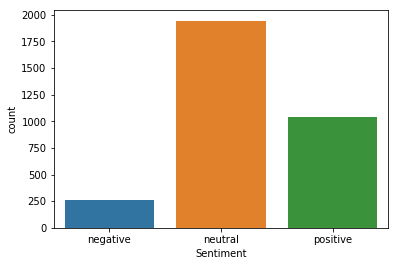

In [13]:
## Revisemos el desglose para Sentiment
sns.countplot(x = 'Sentiment', data = data)
data['Sentiment'].value_counts()

Parece que la mayoría de las personas tienen comentarios positivos o neutrales sobre microfinanzas. De hecho, el volumen de comentarios negativos es el más interesante y debe investigarse más a fondo.

In [14]:
## ¿Cuáles son estos comentarios negativos?

#formatear columnas para que los comentarios no se corten
pd.set_option('display.max_columns', None) 

#extraer comentarios negativos
data.loc[data['Sentiment'] == 'negative']['Comments'].unique()[0:10]

array(["RT @atmadiprayET: Here's why Janalakshmi Financial takes so long to small finance bank transition https://t.co/traKQNXuxe via @economictime\x85",
       "Here's why Janalakshmi Financial takes so long to small finance bank transition https://t.co/traKQNXuxe via\x85 https://t.co/6fk3hc1S9I",
       'RT @The_LHoFT: Why Luxembourg? ???\nA few of the reasons why #Luxembourg is home to a growing number of financial services innovators, inclu\x85',
       '@DataMufti Isnt it surprising that Telenor sold half of its Tameer microfinance stake to Alipay!!! To me it looks like a wrong move.',
       '+???? ????? ???? ??????? ???? \n?????? :NMB MICROFINANCE BITTIYA SANSTHA LIMITED \n?? \n?.Junior Field Officer \n?.Assi\x85 https://t.co/4onBO7RMTc',
       'HR Administrative Assistant at Crossover Microfinance Bank Limited Crossover Microfinance Bank Limited, is ... https://t.co/C9b5PAKKm9',
       'If the bank of Ghana is being this harsh on commercial banks, what will become of savings a

Parece que algunos de los comentarios negativos no son válidos y en realidad deberían clasificarse como neutrales. Sin embargo, algunos de los comentarios negativos son válidos, por ejemplo actividad ilegal.

Por lo general, limpiaríamos estas clasificaciones para corregirlo, pero avanzaremos para preparar nuestros datos para el modelo.

# Preparar datos para el modelo

La forma más común de aplicar algoritmos de aprendizaje automático, como Naive Bayes, al análisis de texto es convertir nuestro texto en vectores de características numéricas que los algoritmos puedan entender.

La representación que crearemos es la **Bag of Words**. Para pasar de nuestros datos, que  están estructurados como una serie de strings, a una bolsa de palabras, **vectorizaremos** nuestros tweets.

Esta **vectorización** de nuestros documentos de texto requerirá algunos pasos clave, que describimos con más detalle en el [Módulo 8]:https://docs.google.com/presentation/d/1vaxDuUROgaqix9Mfkyb4_h0cGkGwN7AUeLU1ozhtJW8/edit#slide=id.g227403103b_0_1171

Paso 0. Divide los datos en conjuntos de entrenamiento y prueba (esto no es parte de la vectorización) <br>
Paso 1. Limpia y **tokeniza** el texto <br>
Paso 2. Cuenta la cantidad de palabras en cada documento

#### Paso 0: Crear datos de entrenamiento y prueba
Este paso debería venir naturalmente.
Hemos clasificado los sentimientos para todos nuestros datos, y elegimos una división de entrenamiento y prueba en proporción 80-20, con observaciones asignadas al azar.

In [15]:
# A) Creamos un conjunto de datos de prueba (20% de datos) y de entrenamiento (80% de datos)
# Establecemos una semilla aleatoria para que pueda ser reproducible

np.random.seed(12345)
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]

In [16]:
# Verificamos el tamaño de los conjuntos de entrenamiento y prueba para confirmar que los datos
# se dividieron en las proporciones correctas
print(len(train), len(test))
print("Split of {:.2%} train, {:.2%} test".format(len(train)/len(data), len(test)/len(data)))

2594 647
Split of 80.04% train, 19.96% test


#### Paso 1: Limpiar y Tokenizar texto

Como se mencionó, la forma más común de extraer vectores numéricos del texto es tener un conjunto de **tokens** que podemos contar.

**Tokenización** significa convertir un documento / oración / tweet en *tokens* individuales, que generalmente son palabras o unidades similares a palabras.

Al crear estos tokens similares a palabras, queremos estandarizarlos de manera que agrupen palabras con una intención similar. Esto hace que estas características de token sean más útiles que las palabras no procesadas. ¡Mira el [Módulo NLP] (https://docs.google.com/presentation/d/1vaxDuUROgaqix9Mfkyb4_h0cGkGwN7AUeLU1ozhtJW8/edit#slide=id.g227403103b_0_1050) para más detalles!

Creamos una función para
+ **lematizar** estas palabras
+ eliminar *stop words*, puntuación, URL, números y caracteres especiales

Afortunadamente, NLTK tiene diferentes bibliotecas que hacen que esta tarea sea muy fácil.

In [17]:
# B) Lematizar palabras y eliminar stop words y puntuaciones
lemmatizer = WordNetLemmatizer()

def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove URLs
    2. Remove punctuation
    3. Remove numbers
    4. Remove stopwords
    5. Return the cleaned text as a list of lemmatized words
    '''
    
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text, flags=re.MULTILINE)
    
    text = ''.join([t for t in text if t not in string.punctuation])
    
    text = ''.join([t for t in text if not t.isdigit()])
    
    return [lemmatizer.lemmatize(word) for word in text.split() if word.lower() not in stopwords.words('english')]

In [18]:
# Probamos la función para asegurarnos que todo funciona tal como lo esperamos
sample_text = "I LOVE love BBQ chicken pizza. I eat it every day, but sometimes I wonder if I'm being unhealthy https://ilove.pizza"
text_process(sample_text)

['LOVE',
 'love',
 'BBQ',
 'chicken',
 'pizza',
 'eat',
 'every',
 'day',
 'sometimes',
 'wonder',
 'Im',
 'unhealthy']

#### Paso 2) Contar el número de palabras en cada 'documento'

Este es el paso que lleva nuestro texto a una representación de *Bag of Words*.

Una bolsa de palabras o *Bag of Words* nos permite trabajar con texto de forma estructurada. Utilizamos un recuento simple de palabras, aunque las bibliotecas de sklearn TF-IDF también están disponibles y pueden usarse para otros problemas de NLP.

Usamos la función **CountVectorizer** de la biblioteca sklearn.

El vectorizador TF-IDF está disponible usando:

`from sklearn.feature_extraction.text import TfidfVectorizer`

Nota la diferencia en el uso de las funciones para ajustar la *bag of words* para datos de prueba versus entrenamiento.

In [19]:
# C) Representar el texto como bag-of-words aprovechando el CountVectorizer de sklearn
vectorizer = CountVectorizer(analyzer=text_process)
train_features = vectorizer.fit_transform(train['Comments'])
test_features =  vectorizer.transform(test['Comments'])

In [ ]:
vectorizer.get_feature_names()[0:20]

Estas son nuestras *características* o *features*, es decir, todos los tokens limpios de todos los tweets. Un tweet de entrenamiento o prueba ahora se puede representar como un recuento de cuántas veces aparece cualquiera de estas características.

In [ ]:
# Probar el vectorizador revisando el tamaño de los vectores
print('Length of Vectorizer Vocabulary: ', len(vectorizer.vocabulary_))
print('Shape of Sparse Matrix: ', test_features.shape)
print('Amount of Non-Zero occurrences: ', test_features.nnz)

# Percentage of non-zero values
density = 100.0 * (test_features.nnz / (test_features.shape[0] * test_features.shape[1]))
print('Density: {}'.format((density)))

Tenemos 4890 *tokens* en nuestro corpus. La matriz de características de datos de prueba es una representación de cada uno de los 647 tweets como un vector de recuento de tokens.

In [ ]:
# Para entender cómo el vectorizer guarda las palabras, revisa el efecto de la función en un Tweet
sample_test = test['Comments'].iloc[0]
print("Sample comment: ", sample_test, "\n")
sample_vector = vectorizer.transform([sample_test])
print("Vectorization:")
print(sample_vector)

In [ ]:
# Esto significa que tenemos 1 ocurrencia para una palabra en el indice 755, 925, etc.
# Podemos usar la función get_feature_names() del vectorizer para ver las palabras correspondientes
print(list(vectorizer.get_feature_names()[i] for i in sample_vector.indices))

Veamos una nube de palabras o *wordclod* de nuestros datos para ver cuales son las palabras que aparecen con mayor frecuencia!

In [ ]:
cloud = WordCloud(width=1600, height=1200, collocations=False).generate(" ".join(data['Comments'].astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

Todavía parece que tenemos algunas URL, y Telenor parece ser un gran problema.

# Introducción a Naive Bayes
Comenzaremos ejecutando Naive Bayes en el texto y comprobaremos qué tan bien funciona en la predicción de clasificaciones. Este paso es muy fácil dado que ya hemos preparado los datos en un formato de bolsa de palabras. <br>

In [ ]:
# Entrenamos usando multinomial NB de sklearn
nb = MultinomialNB()
nb.fit(train_features, train['Sentiment'])

In [ ]:
#Test
preds = nb.predict(test_features)

#imprimir la precisión del modelo
accuracy = (preds == test['Sentiment'])
'Accuracy : {:.2%}'.format(accuracy.sum() / len(accuracy))

La precisión es alta, ~ 84%. La mayoría de los algoritmos de análisis de sentimientos tienen una precisión de ~ 80% cuando ha ajustado el modelo en los datos de entrenamiento adecuados. En este caso, la precisión del 84% probablemente se infla porque hemos usado TextBlob para determinar el sentimiento correcto en nuestros datos de entrenamiento.

La medida actual de precisión es un valor unidimensional. No sabemos en qué nos estamos equivocando cuando clasificamos mal los sentimientos. Una herramienta para comprender mejor cómo estamos clasificando erróneamente se llama matriz de confusión (introducida por primera vez en el módulo X: Regresión logística).

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
class_names = set(data['Sentiment'])
cnf_matrix = confusion_matrix(test['Sentiment'], preds)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, basic NB')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

Los resultados anteriores muestran que comúnmente estamos prediciendo comentarios positivos como neturales. Esta clasificación errónea no es tan preocupante como nuestra segunda clasificación errónea común de comentarios negativos como positivos.

# Mejora 1: Manejo de la negación

Para mejorar Naive Bayes para el análisis de sentimientos, podemos ajustar nuestro tokenizador para la negación en las oraciones. (Consulta las diapositivas de la lección del módulo 10 para obtener más detalles). *Mark negation* es una librería que podemos usar en NLTK que agrega un \"_NEG\" a las palabras después de una negación hasta un signo de puntuación. Esto significa que palabras después de una negación se manejarán de manera diferente a las palabras anteriores a una negación. Podemos investigar si el uso de la negación mejorará nuestro modelo. Dado que Wordnet no clasificó correctamente la negación, este método probablemente no mejorará el modelo.

In [ ]:
# Ejemplo de marcado de negación
print(mark_negation("I like BBQ chicken pizza . I like pepperoni pizza.".split()))
print(mark_negation("I don't like BBQ chicken pizza . I like pepperoni pizza only .".split()))

# Test usando mark_negation con text_process
text = "I don't like BBQ chicken pizza. I like pepperoni pizza only."
print(mark_negation(text_process(text)))

In [ ]:
# Para incorporarlo al modelo Naive Bayes, necesitamos ajustar como procesamos la data para crear el bag of words
vectorizer_negation = CountVectorizer(analyzer='word', tokenizer = lambda text: mark_negation(text_process(text)))
train_features_negation = vectorizer_negation.fit_transform(train['Comments'])
test_features_negation = vectorizer_negation.transform(test['Comments'])

In [ ]:
#entrenar un multinomial NB de sklearn
nb = MultinomialNB()
nb.fit(train_features_negation, train['Sentiment'])

In [ ]:
#Test
preds = nb.predict(test_features_negation)

#imprimir la precisión del modelo
accuracy = (preds == test['Sentiment'])
'Accuracy : {:.2%}'.format(accuracy.sum() / len(accuracy))

Como esperabamos, usar la negación no mejoró la precisión. De hecho, la empeoró!

# Mejora 2: Bigrams
¿Qué pasa si intentamos usar bigramas? ¿Cómo cambiaría la precisión de nuestro modelo el uso de bigramas? Por lo general, incluir bigramas es un buen refuerzo para cualquier tipo de modelo Naive Bayes, no solo aplicado a análisis de sentimientos. CountVectorizer nos facilita la entrada de bigramas en nuestro modelo Naive Bayes usando el parámetro ngram_range. El primer valor en la tupla especifica el ngrama más bajo que rastrearemos, y el segundo, el más alto. En este caso, consideraremos tanto unigramas como bigramas. <br>

In [ ]:
#Usar bigramas con countvectorizer
vectorizer_bigrams = CountVectorizer(analyzer="word", ngram_range = (1,2), encoding='ISO-8859-1', lowercase=False)
train_features_bigrams = vectorizer_bigrams.fit_transform(train['Comments'])
test_features_bigrams  = vectorizer_bigrams.transform(test['Comments'])

In [ ]:
#Testear la función
vectorizer_bigrams.vocabulary_

In [ ]:
#Entrenar un multinomial NB de sklearn
nb = MultinomialNB()
nb.fit(train_features_bigrams, train['Sentiment'])

In [ ]:
#Test
preds = nb.predict(test_features_bigrams)

#imprimir la precisión del modelo
accuracy = (preds == test['Sentiment'])
'Accuracy : {:.2%}'.format(accuracy.sum() / len(accuracy))

Como era de esperar, agregar bigramas mejora ligeramente la precisión de nuestro modelo Naive Bayes. <br>

# Mejora 3: recuento binario Naive Bayes

Otra mejora específica para el análisis de sentimientos es el conteo binario. El uso del conteo binario con Naive Bayes no garantiza que mejore el modelo, pero con frecuencia este lo hace cuando se trata de análisis de sentimientos. Para incorporar esto a nuestro modelo, actualizaremos la función text_process para eliminar duplicados.

In [ ]:
#actualizar la función text_process para eliminar duplicados

def text_process_binary(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned lemmatized text as a list of words
    '''
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    nostopwords = [lemmatizer.lemmatize(word) for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    return list(set(nostopwords))

In [ ]:
#Usar bigramas con countvectorizer
vectorizer_binary = CountVectorizer(analyzer=text_process_binary)
train_features_binary = vectorizer_binary.fit_transform(train['Comments'])
test_features_binary =  vectorizer_binary.transform(test['Comments'])

In [ ]:
#Entrenar un multinomial NB de sklearn
nb = MultinomialNB()
nb.fit(train_features_binary, train['Sentiment'])

In [ ]:
#test
preds = nb.predict(test_features_binary)

#imprimir la precisión del modelo
accuracy = (preds == test['Sentiment'])
'Accuracy : {:.2%}'.format(accuracy.sum() / len(accuracy))


Desafortunadamente, agregar un conteo binario no mejora la precisión de nuestro modelo Naive Bayes en esta muestra de datos. <br>

# Mejora 4: Tratar con texto informal
Por último, otra mejora específica para el análisis de sentimientos es tratar más específicamente con texto informal. Los textos informales comunmente relacionados con el análisis de sentimientos son emojis y textos informales, como texto totalmente en mayúsculas, para representar la emoción. Para tratar con emojis, actualizaremos nuestra función text_process, y para tratar con mayúsculas, desactivaremos el parámetro en minúsculas en el inicializador CountVectorizer. Dado que wordnet no consideró las mayúsculas y los emojis al clasificar los datos en primer lugar, desafortunadamente este método probablemente no cambiará la precisión del modelo.

In [ ]:
#el texto en mayúscula se considera una palabra diferente, y emojis simples

def text_process_informal(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of lemmatized words
    '''
    nopunc = [text[i] for i in range(len(text)) if (text[i] not in string.punctuation) or \
              (text[i:i+2] in [":(", ":)"]) or (text[i]+text[i-1] in [":(", ":)"]) or \
              (text[i:i+2] in ["(:", "):"]) or (text[i]+text[i-1] in ["(:", "):"])]
    nopunc = ''.join(nopunc)
    
    nostopwords = [lemmatizer.lemmatize(word) for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    return nostopwords

In [ ]:
#test para asegurarse que la función funciona bien
text = ":I LOVE love BBQ chicken pizza. I eat it every day, but sometimes I wonder if I'm being unhealthy :) :("
text_process_informal(text)

In [ ]:
#Usar bigramas con countvectorizer
vectorizer_informal = CountVectorizer(analyzer=text_process_informal, lowercase = False)
train_features_informal = vectorizer_informal.fit_transform(train['Comments'])
test_features_informal =  vectorizer_informal.transform(test['Comments'])

In [ ]:
#Entrenar un multinomial NB de sklearn
nb = MultinomialNB()
nb.fit(train_features_informal, train['Sentiment'])

In [ ]:
#test
preds = nb.predict(test_features_informal)

#imprimir la precisión del modelo
accuracy = (preds == test['Sentiment'])
'Accuracy : {:.2%}'.format(accuracy.sum() / len(accuracy))

Como se predijo, la precisión no cambió de Naive Bayes básico.

# Conclusión

Hemos revisado los conceptos básicos de Naive Bayes e investigado cómo se pueden usar las mejoras en el caso del análisis de sentimientos. Nuestros resultados están un poco sesgados debido a la metodología de clasificación original, pero parece que usar bigramas (o cualquier forma de ngramas) fue la forma más efectiva de mejorar el modelo.

Esperamos que este módulo te haya enseñado que los datos de la vida real son desordenados y que construir un modelo es más un arte que una ciencia. Hay muchos tipos de pequeñas mejoras que puede hacer en un modelo Naive Bayes, y a menudo depende de la naturaleza de los datos. Por ejemplo, si sabes que el texto que estás utilizando será particularmente informal, puede ser bueno adaptar la función de tu analizador para tener en cuenta esas informalidades. Si el texto no es informal, este ajuste no cambiará mucho a la precisión del modelo.

Sources: https://medium.com/tensorist/classifying-yelp-reviews-using-nltk-and-scikit-learn-c58e71e962d9, https://www.dataquest.io/blog/naive-bayes-tutorial/, http://nlpforhackers.io/sentiment-analysis-intro/, http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html <br>